In [1]:
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import Voltus_Project_Nathan_Functions as functions

# Initial Data Processing and EDA

In [2]:
# connecting to the server
conn = psycopg2.connect(
    database="interval_load_data",
    user='postgres',
    password='Onei9yepahShac0renga',
    host="test-interval-load-data.cwr8xr5dhgm1.us-west-2.rds.amazonaws.com",
    port="5432"
)

In [4]:
# querying the sites and their time period
site_df = pd.read_sql_query("SELECT site_id, \
                             MIN(interval_end) as time_start, \
                             MAX(interval_end) as time_end, \
                             (MAX(interval_end) - MIN(interval_end)) as series_length, \
                             COUNT(*) as interval_counts, \
                             AVG(interval_width) as mean_interval_width \
                             FROM intervals \
                             GROUP BY site_id;", conn)

In [5]:
# vast majority of data has intervals of 15-minutes or 1-hour
# the 4 other will need to be looked at in more depth
site_df['mean_interval_width'].value_counts()

900.000000     270
3600.000000     93
996.322396       3
949.035874       1
Name: mean_interval_width, dtype: int64

In [6]:
# general inspection
site_df

,site_id,time_start,time_end,series_length,interval_counts,mean_interval_width
0,35f1db19-ab26-7f30-3451-971f053712f6,2015-05-15 05:00:00,2018-10-04 04:00:00,1237 days 23:00:00,118845,900.0
1,a05598bc-59ac-6697-0673-0e87e7ccc677,2018-06-01 05:15:00,2018-10-07 05:00:00,127 days 23:45:00,12288,900.0
2,b8ec0850-c5ce-1579-5438-8d1247f0ff16,2016-09-05 05:00:00,2018-09-07 04:00:00,731 days 23:00:00,17568,3600.0
3,b9ad1c9b-fbe2-f36f-ab2a-6894c251433f,2018-08-17 07:15:00,2018-09-01 07:00:00,14 days 23:45:00,1056,900.0
4,61ff3699-aad4-35d3-4ecb-b8195e8b08cd,2015-01-01 05:00:00,2018-10-22 04:00:00,1389 days 23:00:00,133434,900.0
...,...,...,...,...,...,...
362,debc4593-d7e7-c1ae-f268-f6944c531e3f,2015-05-15 05:00:00,2018-10-12 04:00:00,1245 days 23:00:00,119452,900.0
363,8a2629e5-183b-05c3-7544-5ac89ee3c347,2018-05-04 05:00:00,2018-10-12 04:00:00,160 days 23:00:00,15453,900.0
364,811effd3-85a7-f36f-5eeb-cb38de38d5ac,2017-06-21 04:15:00,2018-10-12 04:00:00,477 days 23:45:00,45888,900.0
365,a85566bd-7cea-eb51-6aa5-912ee6bdd7d7,2015-05-15 05:00:00,2018-10-12 04:00:00,1245 days 23:00:00,119505,900.0


In [7]:
# checking for nulls and confirming datatypes
site_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   site_id              367 non-null    object         
 1   time_start           367 non-null    datetime64[ns] 
 2   time_end             367 non-null    datetime64[ns] 
 3   series_length        367 non-null    timedelta64[ns]
 4   interval_counts      367 non-null    int64          
 5   mean_interval_width  367 non-null    float64        
dtypes: datetime64[ns](2), float64(1), int64(1), object(1), timedelta64[ns](1)
memory usage: 17.3+ KB


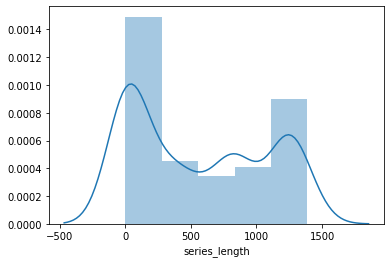

In [8]:
# inspecting the distribution in time series length in days
sns.distplot(site_df['series_length'].dt.days)

In [9]:
# checking for any really small time series and it looks like one might not have enough data to evaluate
# some only have a day of data, but at least you can check that day for start/stop, DR and gaps
site_df['series_length'].sort_values().head()

78    00:00:00
317   23:00:00
213   23:00:00
25    23:00:00
140   23:00:00
Name: series_length, dtype: timedelta64[ns]

In [10]:
# This site only has a single data point, so it will be excluded from further analysis
site_check = pd.read_sql_query("SELECT * \
                               FROM intervals \
                               WHERE site_id='44236c0b-b566-0af2-6675-6854fa9378dd';", conn)
site_check

,kWh,interval_end,interval_width,site_id
0,98.142,2018-08-20 05:15:00,900,44236c0b-b566-0af2-6675-6854fa9378dd


In [11]:
site_df.drop(78, inplace=True)
site_df.reset_index(drop=True, inplace=True)
site_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   site_id              366 non-null    object         
 1   time_start           366 non-null    datetime64[ns] 
 2   time_end             366 non-null    datetime64[ns] 
 3   series_length        366 non-null    timedelta64[ns]
 4   interval_counts      366 non-null    int64          
 5   mean_interval_width  366 non-null    float64        
dtypes: datetime64[ns](2), float64(1), int64(1), object(1), timedelta64[ns](1)
memory usage: 17.3+ KB


In [12]:
# I want to look closer at the sites with unexpected interval lengths
odd_intervals = list(site_df.loc[(site_df['mean_interval_width'] != 900)
                                 & (site_df['mean_interval_width'] != 3600)]['site_id'])

# There is a pattern here where these four sites have 1296 1-hour intervals covering the same period of time.
# Any future algorithms will need to be able to account for this.
for odd_site in odd_intervals:
    interval_check = pd.read_sql_query(f"SELECT * \
                                        FROM intervals \
                                        WHERE site_id='{odd_site}';", conn)
    hour_time_start = interval_check.loc[interval_check['interval_width'] == 3600]['interval_end'].min()
    hour_time_end = interval_check.loc[interval_check['interval_width'] == 3600]['interval_end'].max()
    print(odd_site)
    print(interval_check['interval_width'].value_counts())
    print('Hourly data starts at ',hour_time_start)
    print('Hourly data ends at ',hour_time_end)

e7d819a2-4382-e7d1-a267-069c96a54333
900     35032
3600     1296
Name: interval_width, dtype: int64
Hourly data starts at  2018-09-01 09:00:00
Hourly data ends at  2018-10-25 08:00:00
871f9fba-e8c7-cdcd-1ac4-863509f1be51
900     35032
3600     1296
Name: interval_width, dtype: int64
Hourly data starts at  2018-09-01 09:00:00
Hourly data ends at  2018-10-25 08:00:00
66e9c85d-6b5f-d012-4b56-f69218073f86
900     70064
3600     1296
Name: interval_width, dtype: int64
Hourly data starts at  2018-09-01 09:00:00
Hourly data ends at  2018-10-25 08:00:00
cb846659-8aa0-3233-6b11-6745474c94c3
900     35032
3600     1296
Name: interval_width, dtype: int64
Hourly data starts at  2018-09-01 09:00:00
Hourly data ends at  2018-10-25 08:00:00


In [13]:
# creating a list of sites to be analyzed for use in loops
site_list = list(site_df['site_id'])
len(site_list)

366

In [16]:
# Downloading all the data to a local csv for EDA and prototyping
# that isn't bottlenecked by accessing the database.
# All deliverables will be implemented in a manner that does 
# utilized accessing the database.

# all_data_df = pd.DataFrame()
# for site in site_list:
#     site_data_df = pd.read_sql_query(f"SELECT * \
#                                       FROM intervals \
#                                       WHERE site_id='{site}';"
#                                     , conn)
#     all_data_df = pd.concat([all_data_df,
#                              site_data_df])
# all_data_df.reset_index(drop=True, inplace=True)
# all_data_df.to_csv('data/data.csv', index=False)

In [ ]:
all_data_df = pd.read_csv('data/data.csv')

# Identifying Data Gaps
I wanted to start with this problem because 1) the nature and frequency of the gaps may impact the algorithms used to solve other problems, and 2) I had the clearest initial idea for solving it.

In [14]:
all_gap_dates = functions.multi_site_gap_date_df(site_list)
all_gap_dates.to_csv('deliverables\gap_dates.csv', index=False)